# Explainability of ensemble models with SageMaker Clarify

1. [Overview](#Overview)
1. [Prerequisites and Data](#Prerequisites-and-Data)
    1. [Initialize SageMaker](#Initialize-SageMaker)
    1. [Download data](#Download-data)
    1. [Loading the data: German credit (Update) Dataset](#Loading-the-data:-German-credit-Dataset) 
    1. [Data inspection](#Data-inspection) 
    1. [Data preprocessing Model and upload to S3](#Preprocess-and-Upload-Training-Data) 
1. [Train XGBoost Model](#Train-XGBoost-Model)
    1. [Train Model](#Train-Model)
1. [Train TensorFlow Model](#Train-TensorFlow-Model)
    1. [Train Model](#Train-Model)
1. [Deploy Ensemble Model](#Train-XGBoost-Model)
    1. [Create Model Artifact](#Create-Model-Artifact)
    1. [Create Inference Handler Script ](#Create-Inference-Handler-Script)
    1. [Create Ensemble Container](#Create-Ensemble-Container)
    1. [Deploy Model](#Deploy-Model)
1. [Amazon SageMaker Clarify](#Amazon-SageMaker-Clarify)
    1. [Explaining Predictions](#Explaining-Predictions)
        1. [Viewing the Explainability Report](#Viewing-the-Explainability-Report)
        2. [Explaining individual bad credit prediction example](#Explaining-individual-prediction)
    2. [Understanding Bias](#Bias-Detection)
        1. [Pre-training bias metrics](#pre-training)
        2. [Post-training bias metrics](#post-training)
1. [Clean Up](#Clean-Up)

## Overview
Amazon SageMaker helps data scientists and developers to prepare, build, train, and deploy high-quality machine learning (ML) models quickly by bringing together a broad set of capabilities purpose-built for ML.

[Amazon SageMaker Clarify](https://aws.amazon.com/sagemaker/clarify/) helps improve your machine learning models by detecting potential bias and helping explain how these models make predictions. The fairness and explainability functionality provided by SageMaker Clarify takes a step towards enabling AWS customers to build trustworthy and understandable machine learning models. 

Amazon SageMaker provides pre-made images for machine and deep learning frameworks for supported frameworks such as Scikit-Learn, TensorFlow, PyTorch, MXNet, or Chainer. These are preloaded with the corresponding framework and some additional Python packages, such as Pandas and NumPy, so you can write your own code for model training.See [here](https://docs.aws.amazon.com/sagemaker/latest/dg/algorithms-choose.html#supported-frameworks-benefits) for more information.
Amazon SageMaker [automatic model tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html), also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. 

Amazon SageMaker supports Bring your own model/container for inference. Custom Elastic Container Registry (ECR) images deployed in Amazon SageMaker are expected to adhere to the basic contract described in [Use Your Own Inference Code with Hosting Services](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-inference-code.html) that govern how SageMaker interacts with a Docker container that runs your own inference code. 
[Multi Model Server](https://github.com/awslabs/multi-model-server) is an open source framework for serving machine learning models that can be installed in containers to provide the HTTP front end and model management capabilities required by multi-model endpoints to host multiple models within a single container. The [SageMaker inference toolkit](https://github.com/aws/sagemaker-inference-toolkit) is an implementation for the multi-model server (MMS) that creates endpoints that can be deployed in SageMaker. 

[Amazon SageMaker Studio](https://aws.amazon.com/sagemaker/studio/) provides a single, web-based visual interface where you can perform all ML development activities including notebooks, experiment management, automatic model creation, debugging, and model and data drift detection.

In this SageMaker Studio notebook, we highlight how you can use SageMaker to train models in script-mode with automatic model tuning, host them as an ensemble model in a single custom container for inference, and provide bias detection and explainability to analyze data and understand prediction outcomes from each component of the ensemble model.
This sample notebook walks you through:  

1. Download and explore credit risk dataset - [South German Credit (UPDATE) Data Set](https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29)
2. Preprocessing data with sklearn on the dataset (model 1)
3. Training GBM model with XGboost Auto Tuner on the dataset (model 2)
4. Training Tensorflow 2 model with Tensorflow Auto Tuner on the dataset (model 3)
5. Biuld a single ensemble custom inference container to produce multiple model outcomes per instance
6. Hosting and scoring the single ensemble model (Optional)
7. Single SageMaker Clarify job to provide bias metrics and Kernel SHAP values for each component of the ensemble model on training and test datasets.

![Credit risk explainability with ensemble model inference](Credit_risk_prediction_ensemble_explainability_bias_detection.jpg)

## Prerequisites and Data
### Initialize SageMaker

In [ ]:
import sys
import IPython
install_needed = True  # Set to True to upgrade
if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U sagemaker
    IPython.Application.instance().kernel.do_shutdown(True)

In [1]:
import sagemaker
from sagemaker import Session
session = Session()
bucket = session.default_bucket()
prefix = 'sagemaker/sagemaker-clarify-credit-risk-ensemble-model'
region = session.boto_region_name
# Define IAM role
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import urllib
import os

role = get_execution_role()

### Download data
Data Source: [https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29)

First,  __download__ the data and save it in the local folder

$^{[2]}Ulrike GrÃ¶mping
Beuth University of Applied Sciences Berlin
Website with contact information: https://prof.beuth-hochschule.de/groemping/.

In [2]:
credit_columns = ["status","duration","credit_history","purpose","amount","savings","employment_duration","installment_rate","personal_status_sex","other_debtors","present_residence","property","age","other_installment_plans","housing","number_credits","job","people_liable","telephone","foreign_worker","credit_risk"]


$`laufkont = status`
                                               
 1 : no checking account                       
 2 : ... < 0 DM                                
 3 : 0<= ... < 200 DM                          
 4 : ... >= 200 DM / salary for at least 1 year

$`laufzeit = duration`
     

$`moral = credit_history`
                                                
 0 : delay in paying off in the past            
 1 : critical account/other credits elsewhere   
 2 : no credits taken/all credits paid back duly
 3 : existing credits paid back duly till now   
 4 : all credits at this bank paid back duly    

$`verw = purpose`
                        
 0 : others             
 1 : car (new)          
 2 : car (used)         
 3 : furniture/equipment
 4 : radio/television   
 5 : domestic appliances
 6 : repairs            
 7 : education          
 8 : vacation           
 9 : retraining         
 10 : business          

$`hoehe = amount`
     

$`sparkont = savings`
                               
 1 : unknown/no savings account
 2 : ... <  100 DM             
 3 : 100 <= ... <  500 DM      
 4 : 500 <= ... < 1000 DM      
 5 : ... >= 1000 DM            

$`beszeit = employment_duration`
                     
 1 : unemployed      
 2 : < 1 yr          
 3 : 1 <= ... < 4 yrs
 4 : 4 <= ... < 7 yrs
 5 : >= 7 yrs        

$`rate = installment_rate`
                   
 1 : >= 35         
 2 : 25 <= ... < 35
 3 : 20 <= ... < 25
 4 : < 20          

$`famges = personal_status_sex`
                                         
 1 : male : divorced/separated           
 2 : female : non-single or male : single
 3 : male : married/widowed              
 4 : female : single                     

$`buerge = other_debtors`
                 
 1 : none        
 2 : co-applicant
 3 : guarantor   

$`wohnzeit = present_residence`
                     
 1 : < 1 yr          
 2 : 1 <= ... < 4 yrs
 3 : 4 <= ... < 7 yrs
 4 : >= 7 yrs        

$`verm = property`
                                              
 1 : unknown / no property                    
 2 : car or other                             
 3 : building soc. savings agr./life insurance
 4 : real estate                              

$`alter = age`
     

$`weitkred = other_installment_plans`
           
 1 : bank  
 2 : stores
 3 : none  

$`wohn = housing`
             
 1 : for free
 2 : rent    
 3 : own     

$`bishkred = number_credits`
         
 1 : 1   
 2 : 2-3 
 3 : 4-5 
 4 : >= 6

$`beruf = job`
                                               
 1 : unemployed/unskilled - non-resident       
 2 : unskilled - resident                      
 3 : skilled employee/official                 
 4 : manager/self-empl./highly qualif. employee

$`pers = people_liable`
              
 1 : 3 or more
 2 : 0 to 2   

$`telef = telephone`
                              
 1 : no                       
 2 : yes (under customer name)

$`gastarb = foreign_worker`
        
 1 : yes
 2 : no 

$`kredit = credit_risk`
         
 0 : bad 
 1 : good


In [3]:
training_data = pd.read_csv("data/SouthGermanCredit.txt",
                             names=credit_columns,
                            header=0,
                             sep=r' ',
                             engine='python',
                             na_values="?").dropna()

#training_data.head()
print(training_data.head())

   status  duration  credit_history  purpose  amount  savings  \
0       1        18               4        2    1049        1   
1       1         9               4        0    2799        1   
2       2        12               2        9     841        2   
3       1        12               4        0    2122        1   
4       1        12               4        0    2171        1   

   employment_duration  installment_rate  personal_status_sex  other_debtors  \
0                    2                 4                    2              1   
1                    3                 2                    3              1   
2                    4                 2                    2              1   
3                    3                 3                    3              1   
4                    3                 4                    3              1   

   ...  property  age  other_installment_plans  housing  number_credits  job  \
0  ...         2   21                        3  

### Data inspection
Plotting histograms for the distribution of the different features is a good way to visualize the data. \n
TBD : Let's plot a few of the features that can be considered _sensitive_.  


<AxesSubplot:title={'center':'Counts of Target'}>

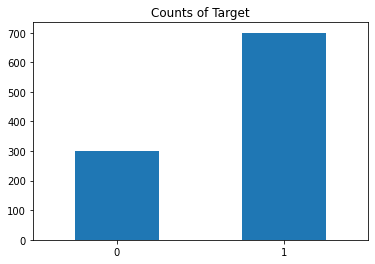

In [4]:
training_data['credit_risk'].value_counts().sort_values().plot(kind='bar', title='Counts of Target', rot=0)

In [ ]:
test_data =  training_data.sample(frac=0.1)
test_data = test_data.drop(['credit_risk'], axis = 1)
test_filename = 'test.csv'
test_data.to_csv(test_filename,index=False,header=False,sep=',')
train_filename = 'train.csv'
training_data.to_csv(train_filename,index=False,header=False,sep=',')

### Encode and Upload Training Data
Here we encode the training and test data. Encoding input data is not necessary for SageMaker Clarify, but is necessary for XGBoost models.

In [6]:
import boto3
from sagemaker.s3 import S3Uploader

s3 = boto3.resource('s3')

file_key = 'data/SouthGermanCredit.txt'

raw = S3Uploader.upload(file_key, 's3://{}/{}/data/raw'.format(bucket, prefix))

In [7]:
test_raw = S3Uploader.upload(test_filename, 's3://{}/{}/data/test'.format(bucket, prefix))
print(test_raw)

s3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/data/test/test.csv


In [86]:
train_raw = S3Uploader.upload(train_filename, 's3://{}/{}/data/train'.format(bucket, prefix))
print(train_raw)

s3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/data/train/train.csv


In [211]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor

sklearn_processor = SKLearnProcessor(role=role,
                                     base_job_name='credit-risk-ensemble-pipeline-proc',
                                     instance_type='ml.m5.large',
                                     instance_count=1,
                                     framework_version='0.20.0')



In [239]:
!cat source_dir/preprocessor.py

import argparse
import os
import warnings

import subprocess
subprocess.call(['pip', 'install', 'sagemaker-experiments'])

import pandas as pd
import numpy as np
import tarfile

from smexperiments.tracker import Tracker

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

columns = ["status","duration","credit_history","purpose","amount","savings","employment_duration","installment_rate","personal_status_sex","other_debtors","present_residence","property","age","other_installment_plans","housing","number_credits","job","people_liable","telephone","foreign_worker","credit_risk"]

if __name__=='__main__':
    
    # Read the arguments passed to the script.
    parser = argparse.ArgumentParser()
    parser.add_arg

In [212]:
raw_data_path = 's3://{0}/{1}/data/raw/'.format(bucket, prefix)
train_data_path = 's3://{0}/{1}/data/preprocessed/train/'.format(bucket, prefix)
val_data_path = 's3://{0}/{1}/data/preprocessed/val/'.format(bucket, prefix)
model_path = 's3://{0}/{1}/sklearn/'.format(bucket, prefix)


sklearn_processor.run(code='source_dir/preprocessor.py',
                      inputs=[ProcessingInput(input_name='raw_data', source=raw_data_path, destination='/opt/ml/processing/input')],
                      outputs=[ProcessingOutput(output_name='train_data', source='/opt/ml/processing/train', destination=train_data_path),
                               ProcessingOutput(output_name='val_data', source='/opt/ml/processing/val', destination=val_data_path),
                               ProcessingOutput(output_name='model', source='/opt/ml/processing/model', destination=model_path)],
                      arguments=['--train-test-split-ratio', '0.2'], logs = False)



Job Name:  credit-risk-ensemble-pipeline-proc-2021-04-02-14-42-29-185
Inputs:  [{'InputName': 'raw_data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/data/raw/', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-436518610213/credit-risk-ensemble-pipeline-proc-2021-04-02-14-42-29-185/input/code/preprocessor.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/data/preprocessed/train/', 'LocalPath': 

In [11]:
file_name = 'train_features.csv'
s3_key_prefix = '{0}/data/preprocessed/train/{1}'.format(prefix, file_name)
print(s3_key_prefix)
session.download_data('./', bucket, s3_key_prefix)
import pandas as pd
df = pd.read_csv(file_name)
x_train = np.array(df)

file_name = 'train_labels.csv'
s3_key_prefix = '{0}/data/preprocessed/train/{1}'.format(prefix, file_name)
print(s3_key_prefix)
session.download_data('./', bucket, s3_key_prefix)
import pandas as pd
df = pd.read_csv(file_name)
y_train = np.array(df)

file_name = 'val_features.csv'
s3_key_prefix = '{0}/data/preprocessed/val/{1}'.format(prefix, file_name)
print(s3_key_prefix)
session.download_data('./', bucket, s3_key_prefix)
import pandas as pd
df = pd.read_csv(file_name)
x_val = np.array(df)

file_name = 'val_labels.csv'
s3_key_prefix = '{0}/data/preprocessed/val/{1}'.format(prefix, file_name)
print(s3_key_prefix)

session.download_data('./', bucket, s3_key_prefix)
import pandas as pd
df = pd.read_csv(file_name)
y_val = np.array(df)

sagemaker/sagemaker-clarify-credit-risk-ensemble-model/data/preprocessed/train/train_features.csv
sagemaker/sagemaker-clarify-credit-risk-ensemble-model/data/preprocessed/train/train_labels.csv
sagemaker/sagemaker-clarify-credit-risk-ensemble-model/data/preprocessed/val/val_features.csv
sagemaker/sagemaker-clarify-credit-risk-ensemble-model/data/preprocessed/val/val_labels.csv


### Train XGBoost Model
#### Train Model 1


In [23]:
!pygmentize source_dir/train_xgboost.py

import argparse
import json
import os
import random
import pandas as pd
import glob
import pickle as pkl

import xgboost

def parse_args():

    parser = argparse.ArgumentParser()

    parser.add_argument("--max_depth", type=int, default=5)
    parser.add_argument("--eta", type=float, default=0.05)
    parser.add_argument("--gamma", type=int, default=4)
    parser.add_argument("--min_child_weight", type=int, default=6)
    parser.add_argument("--silent", type=int, default=0)
    parser.add_argument("--objective", type=str, default="binary:logistic")
    parser.add_argument("--eval_metric", type=str, default="auc")
    parser.add_argument("--num_round", type=int, default=10)
    parser.add_argument("--subsample", type=float, default=0.8)
    parser.add_argument("--early_stopping_rounds", type=int, default=20)
    
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_V

In [203]:
from sagemaker.xgboost import XGBoost

hyperparameters = {
    "max_depth": "5",
    "eta": "0.1",
    "gamma": "4",
    "min_child_weight": "6",
    "silent": "1",
    "objective":'binary:logistic',
    "num_round": "100",
    "subsample": "0.8",
    "eval_metric" : "auc",
    "early_stopping_rounds" : "20"
}


entry_point='train_xgboost.py'
source_dir='source_dir/'
output_path = 's3://{0}/{1}/{2}'.format(bucket, prefix, 'xgb_model')
code_location = 's3://{0}/{1}/code'.format(bucket, prefix)

estimator = XGBoost(
    entry_point=entry_point,
    source_dir=source_dir,
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    instance_type='ml.c5.xlarge', # Specify local as instance type to run local-mode training
    instance_count=1,
    framework_version="0.90-2",
    py_version="py3",
    role=role
)


In [204]:
from sagemaker.inputs import TrainingInput
train_input = TrainingInput('s3://{0}/{1}/data/preprocessed/train/'.format(
    bucket, prefix), content_type='csv')
val_input = TrainingInput('s3://{0}/{1}/data/preprocessed/val/'.format(
    bucket, prefix), content_type='csv')
train_config = sagemaker.session.s3_input('s3://{0}/{1}/data/preprocessed/train/'.format(
    bucket, prefix), content_type='text/csv')
val_config = sagemaker.session.s3_input('s3://{0}/{1}/data/preprocessed/val/'.format(
    bucket, prefix), content_type='text/csv')
inputs = {'train':train_input, 'validation':val_input}

#estimator.fit(inputs, job_name='credit-risk-ensemble-xgb' )

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [205]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': IntegerParameter(1, 10),
                        'gamma': IntegerParameter(1, 5),
                        'max_depth': IntegerParameter(1, 10)}

objective_metric_name = 'validation:auc'
objective_type = 'Maximize'

tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=15,
                            max_parallel_jobs=5,
                            objective_type=objective_type)

tuning_job_name = "xgb-tuner-{}".format(strftime("%d-%H-%M-%S", gmtime()))
tuner.fit(inputs, job_name=tuning_job_name)
tuner.wait()

tuner_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)



.....................................................................................................................!
!


In [206]:
tuner_metrics.dataframe().sort_values(['FinalObjectiveValue'], ascending=False).head(5)

,eta,gamma,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
4,0.014222,4.0,3.0,3.0,xgb-tuner-02-13-14-58-011-9d20e946,Completed,0.824062,2021-04-02 13:22:45+00:00,2021-04-02 13:23:41+00:00,56.0
5,0.001028,4.0,3.0,3.0,xgb-tuner-02-13-14-58-010-6e070ef1,Completed,0.810097,2021-04-02 13:20:24+00:00,2021-04-02 13:21:16+00:00,52.0
10,0.096387,1.0,1.0,2.0,xgb-tuner-02-13-14-58-005-526761f1,Completed,0.798394,2021-04-02 13:17:03+00:00,2021-04-02 13:17:55+00:00,52.0
11,0.139869,4.0,10.0,4.0,xgb-tuner-02-13-14-58-004-caf2130d,Completed,0.798394,2021-04-02 13:16:58+00:00,2021-04-02 13:17:50+00:00,52.0
3,0.256643,5.0,9.0,1.0,xgb-tuner-02-13-14-58-012-f08e34c4,Completed,0.797942,2021-04-02 13:22:57+00:00,2021-04-02 13:23:50+00:00,53.0


In [209]:
xgb_best_training_job = (tuner.best_training_job())

### Train TensorFlow Model
#### Train Model 2

In [213]:
!pygmentize source_dir/train_tf.py

import argparse
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


def parse_args():
    
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--learning_rate', type=float, default=0.1)
    
    # data directories
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))
    
    # model directory: we will use the default set by SageMaker, /opt/ml/model
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    
    return parser.parse_known_args()

def get_mo

In [200]:

from sagemaker.tensorflow import TensorFlow
model_dir = '/opt/ml/model'
hyperparameters = {'epochs': 100, 'batch_size': 8, 'learning_rate': 0.001}
estimator = TensorFlow(source_dir='source_dir',
                             entry_point='train_tf.py',
                             model_dir=model_dir,
                             instance_type='ml.c5.xlarge',
                             instance_count=1,
                             hyperparameters=hyperparameters,
                             role=role,
                             output_path='s3://{}/{}/{}'.format(bucket, prefix, 'tf_model'),
                             framework_version='2.4.1',
                             py_version='py37',
                             script_mode=True)

inputs = {'train':train_input, 'validation':val_input}
#estimator.fit(inputs,job_name='credit-risk-ensemble-tf2')

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {
  'learning_rate': ContinuousParameter(0.001, 0.1, scaling_type="Logarithmic"),
  'epochs': IntegerParameter(50, 200),
  'batch_size': IntegerParameter(8, 256),
}

metric_definitions = [{'Name': 'val_auc',
                       'Regex': ' val_auc: ([0-9\\.]+)'}]

objective_metric_name = 'val_auc'
objective_type = 'Maximize'


tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=15,
                            max_parallel_jobs=5,
                            objective_type=objective_type)

tuning_job_name = "tf2-tuner-{}".format(strftime("%d-%H-%M-%S", gmtime()))
tuner.fit(inputs, job_name=tuning_job_name)
tuner.wait()

tuner_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)



In [202]:
tuner_metrics.dataframe().sort_values(['FinalObjectiveValue'], ascending=False).head(5)

,batch_size,epochs,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
9,219.0,88.0,0.029018,tf2-tuner-02-12-58-31-006-6de39d85,Completed,0.8450,2021-04-02 13:03:36+00:00,2021-04-02 13:04:29+00:00,53.0
5,26.0,170.0,0.002491,tf2-tuner-02-12-58-31-010-84801b71,Completed,0.8359,2021-04-02 13:03:48+00:00,2021-04-02 13:05:06+00:00,78.0
7,134.0,192.0,0.004962,tf2-tuner-02-12-58-31-008-df33fe10,Completed,0.8351,2021-04-02 13:03:27+00:00,2021-04-02 13:04:22+00:00,55.0
13,176.0,173.0,0.002185,tf2-tuner-02-12-58-31-002-585d8abf,Completed,0.8108,2021-04-02 13:00:40+00:00,2021-04-02 13:01:39+00:00,59.0
14,128.0,134.0,0.001556,tf2-tuner-02-12-58-31-001-9206592b,Completed,0.8102,2021-04-02 13:00:17+00:00,2021-04-02 13:01:21+00:00,64.0


In [ ]:
tf2_best_training_job = (tuner.best_training_job())

### Create combined model artifact

In [216]:
preprocessor_model = 's3://{}/{}/{}'.format(bucket, prefix, 'sklearn') + '/model.joblib'
xgboost_model = 's3://{}/{}/{}/{}'.format(bucket, prefix, 'xgb_model',xgb_best_training_job) + '/output/model.tar.gz'
tf_model = 's3://{}/{}/{}/{}'.format(bucket, prefix, 'tf_model',tf2_best_training_job) + '/output/model.tar.gz'
!aws s3 cp {preprocessor_model} ./models/sklearn.joblib
!aws s3 cp {xgboost_model} ./models/xgb.tar.gz
!aws s3 cp {tf_model} ./models/tf.tar.gz
!tar -zcvf modelv3.tar.gz ./models
ensemble_model_url='s3://{}/{}/{}'.format(bucket, prefix,  "ensemble_model/")
print(ensemble_model_url)
session.upload_data(path='modelv3.tar.gz', key_prefix=prefix + "/ensemble_model")

download: s3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/sklearn/model.joblib to models/sklearn.joblib
download: s3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/xgb_model/xgb-tuner-02-13-14-58-011-9d20e946/output/model.tar.gz to models/xgb.tar.gz
download: s3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/tf_model/tf2-tuner-02-12-58-31-006-6de39d85/output/model.tar.gz to models/tf.tar.gz
./models/
./models/sklearn.joblib
./models/tf.tar.gz
./models/xgb.tar.gz
s3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/ensemble_model/


's3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/ensemble_model/modelv3.tar.gz'

### Create custom inference script (multiple outcomes for each prediction - model1 , model2, ensemble)

In [17]:
!cat container/model_handler.py

"""
ModelHandler defines an example model handler for load and inference requests 
"""
from collections import namedtuple
import glob
import json
import logging
import os
import re
import tarfile
import pickle as pkl
import csv
import io
import subprocess
import pandas as pd
import xgboost as xgb
import tensorflow as tf
from sklearn.externals import joblib
from io import StringIO

import numpy as np
from six import BytesIO, StringIO

from sagemaker_inference import content_types, decoder, default_inference_handler, encoder, errors

class ModelHandler(object):     
    
    
    def __init__(self):
        self.initialized = False
        self.preprocessor = None
        self.model1 = None
        self.model2 = None
        self.shapes = None
        self.feature_columns_names = ["status","duration","credit_history","purpose","amount","savings","employment_duration","installment_rate","personal_status_sex","other_debtors","present_residence","property","age","other_installment_plans","h

In [ ]:
import sagemaker
import boto3

try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

In [163]:


sm_client = boto3.client(service_name='sagemaker')
runtime_sm_client = boto3.client(service_name='sagemaker-runtime')

account_id = boto3.client('sts').get_caller_identity()['Account']
region = boto3.Session().region_name


### Create custom container for inference

If you are using SageMaker Studio, Complete the prerequisites mentioned in https://aws.amazon.com/blogs/machine-learning/using-the-amazon-sagemaker-studio-image-build-cli-to-build-container-images-from-your-studio-notebooks/

In [ ]:
#****************if SageMaker Studio , do this  ****************************
import sys
!{sys.executable} -m pip install sagemaker_studio_image_build 

In [182]:
#****************if SageMaker Studio , do this ****************************
%cd "container"
!sm-docker build . --repository byoc-sagemaker-studio-ensemble:1.0 --no-logs
%cd ".."
repo_name ='byoc-sagemaker-studio-ensemble'
image_tag = '1.0'

/root/clarify-demo/credit_risk_ensemble_prediction_explainability/container
Created ECR repository byoc-sagemaker-studio-ensemble
........................................................
Build complete, status = SUCCEEDED
Logs at https://console.aws.amazon.com/cloudwatch/home?region=eu-west-1#logEvent:group=/aws/codebuild/sagemaker-studio-d-qcye4fb3vjo6-hpoonawa-99f-OSaHqLlQGivtIaoU;stream=e735b1fd-734d-423a-b634-a27a1047b4da
Image URI: 436518610213.dkr.ecr.eu-west-1.amazonaws.com/byoc-sagemaker-studio-ensemble:1.0
/root/clarify-demo/credit_risk_ensemble_prediction_explainability


In [ ]:
#****************if SageMaker Notebook instance , do this ****************************
# repo_name ='byoc-sagemaker-ensemble'
# image_tag = 'latest'
# %%sh

# # The name of our algorithm
# algorithm_name=byoc-sagemaker-ensemble

# cd container

# account=$(aws sts get-caller-identity --query Account --output text)

# # Get the region defined in the current configuration (default to us-west-2 if none defined)
# region=$(aws configure get region)
# region=${region:-us-west-2}

# fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# # If the repository doesn't exist in ECR, create it.
# aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

# if [ $? -ne 0 ]
# then
#     aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
# fi

# # Get the login command from ECR and execute it directly
# $(aws ecr get-login --region ${region} --no-include-email)

# # Build the docker image locally with the image name and then push it to ECR
# # with the full name.

# docker build -q -t ${algorithm_name} .
# docker tag ${algorithm_name} ${fullname}

# docker push ${fullname}


### Create SageMaker model to be deployed

In [219]:
from sagemaker.predictor import Predictor
import boto3
from time import gmtime, strftime
model_name = 'BYOC-EnsembleModel' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_url='s3://{}/{}/{}'.format(bucket, prefix,  "ensemble_model/") + 'modelv3.tar.gz'
image_uri = '{}.dkr.ecr.{}.amazonaws.com/{}:{}'.format(account_id, region, repo_name,image_tag)

print('Model name: ' + model_name)
print('Model data Url: ' + model_url)
print('Container image: ' + image_uri)

container = {
    'Image': image_uri,
    'ModelDataUrl': model_url,
    'Mode': 'SingleModel'
}

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    Containers = [container])

print("Model Arn: " + create_model_response['ModelArn'])

Model name: BYOC-EnsembleModel2021-04-02-14-55-17
Model data Url: s3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/ensemble_model/modelv3.tar.gz
Container image: 436518610213.dkr.ecr.eu-west-1.amazonaws.com/byoc-sagemaker-studio-ensemble:1.0
Model Arn: arn:aws:sagemaker:eu-west-1:436518610213:model/byoc-ensemblemodel2021-04-02-14-55-17


In [220]:
endpoint_config_name = 'BYOC-EnsembleModelEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print('Endpoint config name: ' + endpoint_config_name)
predictor_instance_type = 'ml.t2.large'
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType': predictor_instance_type,
        'InitialInstanceCount': 1,
        'InitialVariantWeight': 1,
        'ModelName': model_name,
        'VariantName': 'AllTraffic'}])

print("Endpoint config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

Endpoint config name: BYOC-EnsembleModelEndpointConfig-2021-04-02-14-56-03
Endpoint config Arn: arn:aws:sagemaker:eu-west-1:436518610213:endpoint-config/byoc-ensemblemodelendpointconfig-2021-04-02-14-56-03


### Deploy model endpoint (Optional)

In [221]:
import time

endpoint_name = 'BYOC-EnsembleModelEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print('Endpoint name: ' + endpoint_name)

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print('Endpoint Arn: ' + create_endpoint_response['EndpointArn'])



Endpoint name: BYOC-EnsembleModelEndpoint-2021-04-02-14-56-25
Endpoint Arn: arn:aws:sagemaker:eu-west-1:436518610213:endpoint/byoc-ensemblemodelendpoint-2021-04-02-14-56-25


In [222]:
#endpoint_name = 'BYOC-MultiModelEndpoint-2020-10-28-21-57-13'
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Endpoint Status: " + status)

print('Waiting for {} endpoint to be in service...'.format(endpoint_name))
waiter = sm_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

Endpoint Status: Creating
Waiting for BYOC-EnsembleModelEndpoint-2021-04-02-14-56-25 endpoint to be in service...


### Invoke endpoint for multiple outcome predictions (Optional)

In [223]:
print(model_name)

BYOC-EnsembleModel2021-04-02-14-55-17


In [224]:
print(endpoint_name)

BYOC-EnsembleModelEndpoint-2021-04-02-14-56-25


In [ ]:
print(train_raw)

In [ ]:
print(test_raw)

In [228]:
from io import StringIO
test_dataset = sagemaker.s3.S3Downloader.read_file(test_raw)
predictor = sagemaker.predictor.Predictor(endpoint_name, session, serializer=sagemaker.serializers.CSVSerializer(), deserializer=sagemaker.deserializers.CSVDeserializer())
predictor.predict(test_dataset)

[['[0.67,0.77,0.72,]',
  '[0.68,0.74,0.71,]',
  '[0.74,0.86,0.80,]',
  '[0.56,0.64,0.60,]',
  '[0.81,0.90,0.86,]',
  '[0.53,0.57,0.55,]',
  '[0.60,0.83,0.71,]',
  '[0.63,0.83,0.73,]',
  '[0.47,0.56,0.52,]',
  '[0.51,0.59,0.55,]',
  '[0.52,0.64,0.58,]',
  '[0.49,0.65,0.57,]',
  '[0.80,0.79,0.80,]',
  '[0.61,0.75,0.68,]',
  '[0.38,0.59,0.48,]',
  '[0.73,0.86,0.79,]',
  '[0.62,0.75,0.69,]',
  '[0.66,0.63,0.64,]',
  '[0.71,0.88,0.79,]',
  '[0.71,0.86,0.79,]',
  '[0.60,0.65,0.63,]',
  '[0.77,0.82,0.80,]',
  '[0.46,0.59,0.53,]',
  '[0.57,0.70,0.64,]',
  '[0.62,0.70,0.66,]',
  '[0.78,0.80,0.79,]',
  '[0.43,0.58,0.50,]',
  '[0.73,0.92,0.82,]',
  '[0.56,0.70,0.63,]',
  '[0.55,0.61,0.58,]',
  '[0.63,0.78,0.70,]',
  '[0.54,0.74,0.64,]',
  '[0.79,0.80,0.79,]',
  '[0.68,0.91,0.79,]',
  '[0.70,0.91,0.80,]',
  '[0.60,0.76,0.68,]',
  '[0.73,0.70,0.71,]',
  '[0.53,0.62,0.57,]',
  '[0.81,0.83,0.82,]',
  '[0.65,0.84,0.75,]',
  '[0.80,0.77,0.79,]',
  '[0.79,0.82,0.80,]',
  '[0.80,0.83,0.82,]',
  '[0.81,0.

## Amazon SageMaker Clarify
Now that you have your model set up. Let's say hello to SageMaker Clarify!

In [229]:
from sagemaker import clarify
clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.c4.xlarge',
                                                      sagemaker_session=session)

### Explaining Predictions
There are expanding business needs and legislative regulations that require explainations of _why_ a model mades the decision it did. SageMaker Clarify uses SHAP to explain the contribution that each input feature makes to the final decision.

In [230]:
print(training_data.columns.to_list())

['status', 'duration', 'credit_history', 'purpose', 'amount', 'savings', 'employment_duration', 'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans', 'housing', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker', 'credit_risk']


In [232]:
print(test_data.columns.to_list())

['status', 'duration', 'credit_history', 'purpose', 'amount', 'savings', 'employment_duration', 'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans', 'housing', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker']


In [63]:
print(test_data.shape)

(100, 20)


We are interested in explaining bad credit predictions. Hence, we would like the the baseline choice to have E(x) closer to 1(belonging to the good credit class). For more information on selecting informative vs non-informative baselines, see the documentation [here](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-feature-attribute-shap-baselines.html)

In [233]:
#we use the mode of training data as baseline for SHAP , must be same data type (int) as input features
baseline = training_data.drop(['credit_risk'], axis = 1).mode().iloc[0].values.astype('int').tolist()
print(baseline)
#check baseline prediction E[(x)] 
pred_baseline = predictor.predict(baseline)
print(pred_baseline)

[4, 24, 2, 3, 1258, 1, 3, 4, 3, 1, 4, 3, 27, 3, 2, 1, 3, 2, 1, 2]
[['[0.80,0.76,0.78,]']]


In [237]:
# Refer the api documentation here https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify.SHAPConfig
shap_config = clarify.SHAPConfig(baseline=[baseline],
                                 num_samples=2000, #num_samples are permutations from your features, so should be large enough as compared to number of input features, for example, 2k + 2* num_features
                                 agg_method='mean_abs',
                                 use_logit=True) #we want the shap values to have log-odds units so that the equation 'shap values + expected probability =  predicted probability' for each instance record )

explainability_output_path = 's3://{}/{}/clarify-explainability-3'.format(bucket, prefix)

explainability_data_config = clarify.DataConfig(s3_data_input_path=test_raw,
                                s3_output_path=explainability_output_path,
                                #label='credit_risk', # target column is not present in the test dataset
                                headers=test_data.columns.to_list(),
                                dataset_type='text/csv')

model_config = clarify.ModelConfig(model_name=model_name,
                                   instance_type='ml.c5.xlarge',
                                   instance_count=1,
                                   accept_type='text/csv')

In [235]:
#we define model_scores=0 to indicate that the first index is the predicted value and it consists of a tuple of values for each model outcome
clarify_processor.run_explainability(data_config=explainability_data_config,
                                     model_config=model_config,
                                     explainability_config=shap_config,model_scores=0)


Job Name:  Clarify-Explainability-2021-04-02-15-21-15-466
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/data/test/test.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/clarify-explainability-3/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/clarif

#### Viewing the Explainability Report
You can view the explainability report in Studio under the experiments tab


<img src="./recordings/explainability_detail.gif">

The Model Insights tab contains direct links to the report and model insights.

If you're not a Studio user yet, as with the Bias Report, you can access this report at the following S3 bucket.

In [ ]:
explainability_output_path

## Look at individual ensemble  predictions of bad credit in the test dataset and their corresponding SHAP values 

In [151]:
from sagemaker.s3 import S3Downloader
import json
import io

# read the shap values
S3Downloader.download(s3_uri=explainability_output_path+"/explanations_shap", local_path="output")
shap_values_df = pd.read_csv("output/out.csv")
print(shap_values_df.shape)

# read the inference results
print(type(predictions[0]))
predictions_df = pd.read_csv(io.StringIO('\n'.join(predictions[0])), delim_whitespace=True,header=None)
predictions_df.columns = ['result']
#print((predictions_df['result'].tolist()[0]))
predictions_df['ensemble_prob'] =  predictions_df.apply (lambda row: row['result'][11:15], axis=1)

# get the base expected value to be used to plot SHAP values
S3Downloader.download(s3_uri=explainability_output_path+"/analysis.json", local_path="output")

with open('output/analysis.json') as json_file:
    data = json.load(json_file)
    base_value = data['explanations']['kernel_shap']['label2']['expected_value']

print("base value: ", base_value)

# join the probability score and shap values together in a single data frame
predictions_df.reset_index(drop=True, inplace=True)
shap_values_df.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
prediction_shap_df = pd.concat([predictions_df,shap_values_df,test_data],axis=1)
#print(prediction_shap_df)
print(test_data.shape)
prediction_shap_df["ensemble_prob"] = pd.to_numeric(prediction_shap_df["ensemble_prob"], downcast="float")
#create a new column as 'Prediction' converting the ensemble probability to either 1 or 0
prediction_shap_df.insert(0,'Prediction', (prediction_shap_df['ensemble_prob'] > 0.5).astype(int))
bad_credit_outcomes_df = prediction_shap_df[prediction_shap_df.iloc[:, 0] == 0]
#print(bad_credit_outcomes_df)

(100, 60)
<class 'list'>
base value:  1.4500101755059986
(100, 20)


#### Install open source SHAP library for more visualizations

In [78]:
!conda install -c conda-forge shap -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.0               |   py37h89c1867_0         3.1 MB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    shap-0.37.0                |   py37h10a2094_0         510 KB  conda-forge
    slicer-0.0.7               |     pyhd8ed1ab_0          16 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.6 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/linux-64::python_abi-3.7-1_cp37

In [79]:
import shap

#### SHAP summary plot for each individual bad credit prediction instance in the dataset

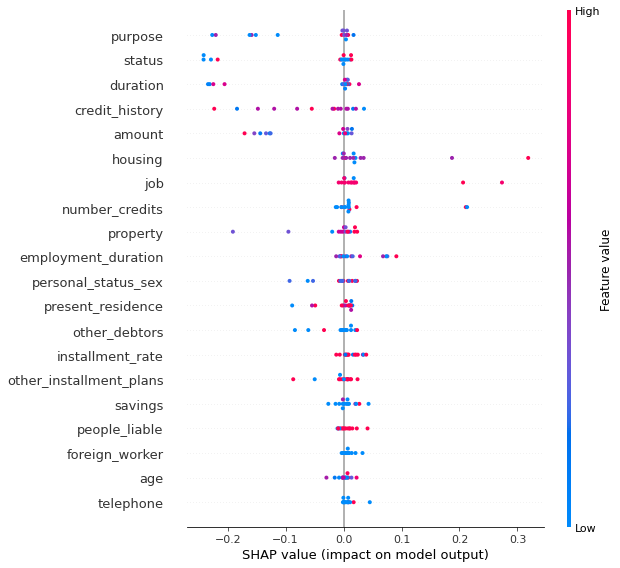

In [152]:
shap.summary_plot(bad_credit_outcomes_df.iloc[:,43:63].to_numpy(), bad_credit_outcomes_df.iloc[:,63:83].to_numpy(),feature_names=test_data.columns)

#### SHAP explanation plot for a single bad credit ensemble prediction instance 

In [81]:
!pip install matplotlib

In [160]:
import matplotlib.pyplot as plt
min_index = prediction_shap_df['ensemble_prob'].idxmin()
print(min_index)
print('mean probability of dataset')
print(prediction_shap_df[['ensemble_prob']].mean())
print('individual probability')
print(prediction_shap_df.iloc[71,2])
print('sum of shap values')
print(prediction_shap_df.iloc[71,43:63].sum())
print('base value from analysis.json')
print(base_value)

71
mean probability of dataset
ensemble_prob    0.7447
dtype: float32
individual probability
0.29
sum of shap values
-0.30811709449032854
base value from analysis.json
1.4500101755059986


Example 'bad credit ' prediction SHAP values.
Note that by default SHAP explains classifer models in terms of their margin output, before the logistic link function. That means the units on the x-axis are log-odds units, so negative values imply probabilies of less than 0.5 meaning bad credit. 
The following is expected to hold true : 

E(y) < 0 implies average probability less than 0.5 (bad credit baseline)

E(y) > 0 implies average probability greater than  0.5 (good credit baseline)

y < 0 implies predicted probability less than 0.5 (bad credit)

y > 0 implies predicted probability greater than  0.5 (good credit) 

sum(SHAP values) + E(y)) == model_prediction_logit

logistic(model_prediction_logit) = model_prediction_probability


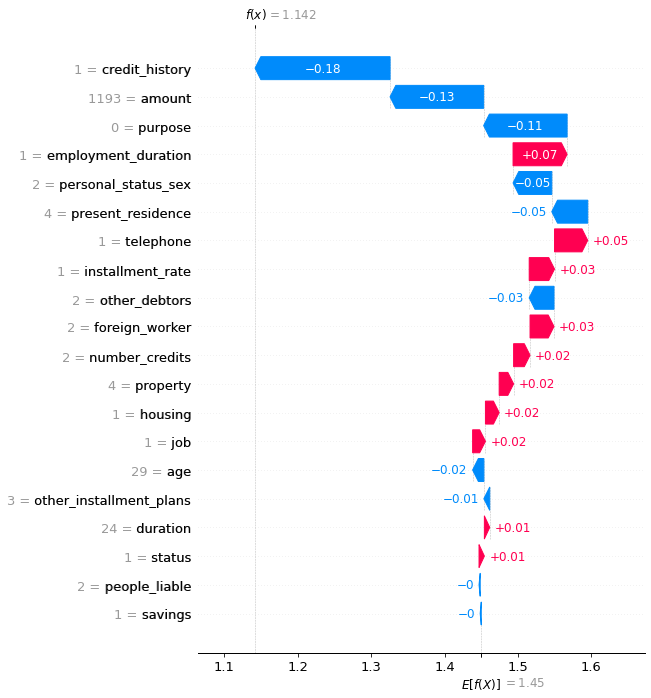

In [240]:
explanation_obj = shap._explanation.Explanation(values=prediction_shap_df.iloc[min_index,43:63].to_numpy(), base_values=base_value, data=test_data.iloc[min_index].to_numpy(),feature_names=test_data.columns)
shap.plots.waterfall(shap_values=explanation_obj, max_display=20, show=False)

### Bias metrics

In [87]:
print(training_data.columns.to_list())

['status', 'duration', 'credit_history', 'purpose', 'amount', 'savings', 'employment_duration', 'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans', 'housing', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker', 'credit_risk']


In [96]:
bias_report_output_path = 's3://{}/{}/clarify-bias'.format(bucket, prefix)
bias_data_config = clarify.DataConfig(s3_data_input_path=train_raw,
                                      s3_output_path=bias_report_output_path,
                                      label='credit_risk',
                                      headers=training_data.columns.to_list(),
                                      dataset_type='text/csv')
predictions_config = clarify.ModelPredictedLabelConfig(label=None,probability=0)

In [97]:
bias_config = clarify.BiasConfig(label_values_or_threshold=[1],
                                facet_name='age',
                                facet_values_or_threshold=[40],
                                group_name='personal_status_sex')

In [98]:
clarify_processor.run_bias(data_config=bias_data_config,
                           bias_config=bias_config,
                           model_config=model_config,
                           model_predicted_label_config=predictions_config,
                           pre_training_methods='all',
                           post_training_methods='all')


Job Name:  Clarify-Bias-2021-04-01-06-46-40-780
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/data/train/train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/clarify-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-eu-west-1-436518610213/sagemaker/sagemaker-clarify-credit-risk-ensemble-model/clarify-bias', 'LocalPath'

#### Viewing the Bias detection Report
You can view the bis detection report in Studio under the experiments tab 

If you're not a Studio user yet,  you can access this report at the following S3 bucket.

In [ ]:
bias_report_output_path

### Clean Up
Finally, don't forget to clean up the resources we set up and used for this demo!

In [ ]:
session.delete_endpoint(endpoint_name)

In [ ]:
session.delete_model(model_name)